In [112]:
import numpy as np 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
from geopy.distance import geodesic

from lib.EFSpy_module import EFS
from tqdm import tqdm, trange
import copy
import time
from multitaper import MTSpec, mtspec
import struct
from scipy import sparse


In [5]:
def read_spec(filepath, prec_wf='float32', prec_bp='int32'):
    """Function to read .spec files outputted by Peter Shearer's fortran
    codes.

    Args:
        filepath (str): Path of the .spec file to read

    Returns:
        shead: Spectral method header info
        ehead: Event header info
        spec: Spectra

    Sources:

    Last Modified:
        2024-09-03
    """

    f = open(filepath, 'rb')
    f.seek(0, 2)
    file_size = f.tell()
    f.seek(0, 0)

    spec = []

    shead = {}
    ehead = {}

    junk = struct.unpack('i', f.read(4))[0]
    shead['ispec_method'] = struct.unpack('i', f.read(4))[0]
    shead['ntwind'] = struct.unpack('i', f.read(4))[0]
    shead['nf'] = struct.unpack('i', f.read(4))[0]
    shead['twindoff'] = struct.unpack('f', f.read(4))[0]
    shead['dt'] = struct.unpack('f', f.read(4))[0]
    shead['df'] = struct.unpack('f', f.read(4))[0]    
    # print('shead: ', shead)

    junk1 = struct.unpack('i', f.read(4))[0]
    junk2 = struct.unpack('i', f.read(4))[0]
    # print('junk1: ', junk1)
    # print('junk2: ', junk2)
    ehead['efslabel'] = f.read(40).decode('UTF-8').strip('\x00')
    # print("efslabel: ", ehead['efslabel'])
    ehead['datasource'] = f.read(40).decode('UTF-8').strip('\x00')
    ehead['maxnumts'] = struct.unpack('i', f.read(4))[0]
    ehead['numts'] = struct.unpack('i', f.read(4))[0]
    ehead['cuspid'] = struct.unpack('i', f.read(4))[0]
    ehead['qtype'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag1type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag2type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag3type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmomenttype'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qlocqual'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qfocalqual'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qlat'] = struct.unpack('f', f.read(4))[0]
    ehead['qlon'] = struct.unpack('f', f.read(4))[0]
    ehead['qdep'] = struct.unpack('f', f.read(4))[0]
    ehead['qsc'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag1'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag2'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag3'] = struct.unpack('f', f.read(4))[0]
    ehead['qmoment'] = struct.unpack('f', f.read(4))[0]
    ehead['qstrike'] = struct.unpack('f', f.read(4))[0]
    ehead['qdip'] = struct.unpack('f', f.read(4))[0]
    ehead['qrake'] = struct.unpack('f', f.read(4))[0]
    ehead['qyr'] = struct.unpack('i', f.read(4))[0]
    ehead['qmon'] = struct.unpack('i', f.read(4))[0]
    ehead['qdy'] = struct.unpack('i', f.read(4))[0]
    ehead['qhr'] = struct.unpack('i', f.read(4))[0]
    ehead['qmn'] = struct.unpack('i', f.read(4))[0]
    # print('ehead: ', ehead)

    # 20 4-byte fields reserved for future uses - skip (80 bytes)
    for idum in range(0, 20):
        dummy = struct.unpack('i', f.read(4))[0]
        # print(str(dummy) + ", ", end="")
    # print("")
    # dummy = struct.unpack('i', f.read(80))[0]

    # Get byte positions for all time series (i64 or i32 arrays)
    # bytepos = np.fromfile(f, dtype = prec_bp, count = ehead['numts'])
    # ehead['bytepos'] = bytepos

    # print(bytepos)

    # bytepos[0] += 4

    # Now loop over all the time series
    for ii in range(0, ehead['numts']):
        # print("TSSHEAD %i of %i\n---------------------" % (ii, ehead['numts']))

        # Assemble tshead
        # f.seek(bytepos[ii]+40)
        # print(bytepos[ii])
        tshead = {}
        junk1 = struct.unpack('i', f.read(4))[0]
        junk2 = struct.unpack('i', f.read(4))[0]
        
        # print(junk1, junk2)
        tshead['stname'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['loccode'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['datasource'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['sensor'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['units'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['chnm'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['stype'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['dva'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick1q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick2q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick3q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick4q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick1name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick2name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick3name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick4name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['ppolarity'] = f.read(4).decode('UTF-8').strip('\x00')
        # print(tshead)
        tshead['problem'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['npts'] = struct.unpack('i', f.read(4))[0]
        tshead['syr'] = struct.unpack('i', f.read(4))[0]
        tshead['smon'] = struct.unpack('i', f.read(4))[0]
        tshead['sdy'] = struct.unpack('i', f.read(4))[0]
        tshead['shr'] = struct.unpack('i', f.read(4))[0]
        tshead['smn'] = struct.unpack('i', f.read(4))[0]
        tshead['compazi'] = struct.unpack('f', f.read(4))[0]
        tshead['compang'] = struct.unpack('f', f.read(4))[0]
        tshead['gain'] = struct.unpack('f', f.read(4))[0]
        tshead['f1'] = struct.unpack('f', f.read(4))[0]
        tshead['f2'] = struct.unpack('f', f.read(4))[0]
        tshead['dt'] = struct.unpack('f', f.read(4))[0]
        tshead['ssc'] = struct.unpack('f', f.read(4))[0]
        tshead['tdif'] = struct.unpack('f', f.read(4))[0]
        tshead['slat'] = struct.unpack('f', f.read(4))[0]
        tshead['slon'] = struct.unpack('f', f.read(4))[0]
        tshead['selev'] = struct.unpack('f', f.read(4))[0]
        tshead['deldist'] = struct.unpack('f', f.read(4))[0]
        tshead['sazi'] = struct.unpack('f', f.read(4))[0]
        tshead['qazi'] = struct.unpack('f', f.read(4))[0]
        tshead['pick1'] = struct.unpack('f', f.read(4))[0]
        tshead['pick2'] = struct.unpack('f', f.read(4))[0]
        tshead['pick3'] = struct.unpack('f', f.read(4))[0]
        tshead['pick4'] = struct.unpack('f', f.read(4))[0]
        # print(tshead)

        # print('dummy: ', end="")
        # 20 4-byte fields reserved for future uses - skip
        for idum in range(0, 22):
            dummy = struct.unpack('i', f.read(4))[0]
            # print(str(dummy) + ", ", end="")
        # dummy = struct.unpack('i', f.read(80))[0]
        # print("")

        # Read the windowed data and spectra
        x1out = np.fromfile(f, dtype = prec_wf, count = shead['ntwind'])
        x2out = np.fromfile(f, dtype = prec_wf, count = shead['ntwind'])

        s1out = np.fromfile(f, dtype = prec_wf, count = shead['nf'])
        s2out = np.fromfile(f, dtype = prec_wf, count = shead['nf'])

        # Bundle tsheader and time-series for this waveform into efsdata, then append to list
        tshead['x1'] = x1out
        tshead['x2'] = x2out
        tshead['s1'] = s1out
        tshead['s2'] = s2out
        spec.append(tshead)

        # some have fewer spectra than numts for some reason
        if file_size - f.tell() < 10: break
        # print("%i of %i bytes remaining" % (file_size - f.tell(), file_size))
        # print('first data: ', x1out[:10])
        # print('second spect: ', s2out[-10:])

        # plt.figure()
        # plt.plot(s1out)
        # plt.plot(s2out)
        # plt.show()
    f.close()

    ehead['numts'] = len(spec)

    return shead, ehead, spec

In [271]:
# SpecDecomp parameters
travel_time_bin_increment = 1

# post-SpecDecomp processing
calibration_mag = [1.4, 1.6]
calibration_dist = 20
calibration_depth = 5
calibration_nmin = 5
calibration_fc = 30.0

target_mag_min = 2.0


kP = 0.38



spec_dir = "data/spec_files/"
procspec_dir = "data/proc_spec/"


In [277]:
# These lists hold the names of the values for the following:
#   skeys: values that depend solely on station
#   ekeys: values that depend solely on event
#   pkeys: values that depend on the event-station pair
#   ev_pkeys: same as above, but without x2 and s2 arrays
skeys = ['stname','loccode','units','chnm','stype','slat','slon','selev']
ekeys = ['cuspid','numts','qmag1','qmag1type','qlat','qlon','qdep','qsc']
pkeys = ['npts','dt','tdif','deldist','pick1','x2','s2']
ev_pkeys = ['npts','dt','tdif','deldist','pick1']
allkeys = [*ekeys, *skeys, *pkeys]

tt_bins = np.arange(0, 22, travel_time_bin_increment)


spec_files = [el for el in os.listdir(spec_dir) if el.endswith('.spec')]

shead, _, _ = read_spec(spec_dir + spec_files[0])

ntwind      = shead['ntwind']
nf          = shead['nf']
twindoff    = shead['twindoff']
dt          = shead['dt']
df          = shead['df']

try:
    # raise ValueError()
    data = pd.read_pickle("data/proc_spec/data_table.pkl")
    event_ids = np.loadtxt(procspec_dir + "event_ids.txt", dtype=int)
    station_ids = np.loadtxt(procspec_dir + "station_ids.txt", dtype=str)
    print("DataFrame successfully loaded")
except:
    print("Failed to load pre-computed DataFrame. Computing now...")
    D = []
    for i in trange(len(spec_files), desc='reading .spec files: '):
        filepath = spec_dir + spec_files[i]
        # read .spec files
        shead, ehead, spec = read_spec(filepath)

        edata = {key: ehead[key] for key in ekeys}

        for j in range(len(spec)):
            sdata = {key: spec[j][key] for key in skeys}
            pdata = {key: spec[j][key] for key in pkeys}
            D.append({**edata, **sdata, **pdata})
    data = pd.DataFrame(D)
    data['station_id'] = data[['stype', 'stname', 'loccode', 'chnm']].apply(lambda x: '.'.join(x[x.notnull()]), axis=1)

    # for some reason, some values of 'pick1' are zero. Toss these.
    data = data.drop(np.where(data['pick1'].values==0.0)[0])

    # bin values by travel time
    data['ttind'] = np.searchsorted(tt_bins, data['pick1'].values.astype(float)) - 1

    # assign event- and station-specific integer ids   
    event_ids = np.unique(data['cuspid'].values)
    station_ids = np.unique(data['station_id'].values)
    event_ids.sort()
    station_ids.sort()
    data['stind'] = [np.where(el == station_ids)[0][0] for el in data['station_id'].values]
    data['evind'] = [np.where(el == event_ids)[0][0] for el in data['cuspid'].values]
    
    # sort, re-index, and save
    data.sort_values(by=['cuspid', 'station_id'], inplace=True)
    data.reset_index(inplace=True, drop=True)
    data.to_pickle("data/proc_spec/data_table.pkl")
    np.savetxt(procspec_dir + "event_ids.txt", event_ids, fmt='%i', delimiter='\n')
    np.savetxt(procspec_dir + "station_ids.txt", station_ids, fmt='%s', delimiter='\n')

# append new values to the keys lists
skeys += ['station_id', 'stind']
ekeys += ['evind']
pkeys += ['ttind']
ev_pkeys += ['ttind']

ndata = len(data)
nstations = max(data['stind']) + 1
nevents = max(data['evind']) + 1
nttbins = len(np.unique(data['ttind']))


DataFrame successfully loaded


Setup inverse problem and solve

In [278]:
# form an (ndata x nf) matrix of log spectra
d = np.log10(np.array([el.reshape((nf)) for el in data['s2'].values]))

# Ge, Gs, and Gr represent the event, station, and distance blocks of G
# d and i arrays are the same for each block: d is just ones, and i are the
# row numbers
d_array = np.ones(ndata, dtype=int) # values at coordinates i,j
i_array = np.arange(ndata, dtype=int) # i coordinates

# Events
j_array = data['evind'].values.astype(int) # j coordinates
Ge = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# Stations
j_array = data['stind'].values.astype(int) # j coordinates
Gs = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# Distances
j_array = data['ttind'].values.astype(int) # j coordinates
Gr = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# stack all blocks together
G = sparse.hstack((Ge, Gs, Gr))

print("d-array shape:            ", d.shape)
print("-----------------------------------------")
print("Event block shape:        ", Ge.shape)
print("Station block shape:      ", Gs.shape)
print("Distance bin block shape: ", Gr.shape)
print("-----------------------------------------")
print("Resulting G matrix shape: ", G.shape)


# solve the inverse problem at each frequency point
# split into event, station, and distance terms
print("Solving inverse problem...")
e = np.empty((nevents, nf), dtype=float)
s = np.empty((nstations, nf), dtype=float)
t = np.empty((nttbins, nf), dtype=float)

for i in trange(nf):
    x = sparse.linalg.lsqr(G, d[:,i], iter_lim=10000)
    e[:,i] = x[0][:nevents]
    s[:,i] = x[0][nevents:nevents+nstations]
    t[:,i] = x[0][nevents+nstations:]

data['ev_term'] = [el.flatten() for el in np.vsplit(e[np.searchsorted(event_ids, data['cuspid'].values),:], ndata)]
data['st_term'] = [el.flatten() for el in np.vsplit(s[np.searchsorted(station_ids, data['station_id'].values),:], ndata)]
data['tt_term'] = [el.flatten() for el in np.vsplit(t[np.searchsorted(tt_bins, data['ttind'].values),:], ndata)]

# skeys += ['st_term']
# ekeys += ['ev_term']

# form a dataframe with one line per event, and group station-dependent values in lists
ev = data[skeys+ekeys+ev_pkeys].groupby(ekeys, as_index=False)[skeys+ev_pkeys].agg(list)


d-array shape:             (23784, 151)
-----------------------------------------
Event block shape:         (23784, 3125)
Station block shape:       (23784, 80)
Distance bin block shape:  (23784, 21)
-----------------------------------------
Resulting G matrix shape:  (23784, 3226)
Solving inverse problem...


  9%|▉         | 14/151 [00:02<00:19,  7.05it/s]

In [212]:
# f = np.arange(0, nf) * df/2
# ttmids = (tt_bins[1:] + tt_bins[:-1]) / 2
# plt.figure(figsize=(10,8))
# for i in range(nttbins):    
#     plt.plot(f, t[i,:], c=[1,i/nttbins,0], label=ttmids[i])
# plt.legend()
# plt.title(f'Travel-time terms (n = {nttbins})')
# plt.show()

# f = np.arange(0, nf) * df/2
# plt.figure(figsize=(10,8))
# plt.plot(f, s.T)
# plt.title(f'Station terms (n = {nstations})')
# plt.show()

# f = np.arange(0, nf) * df/2
# plt.figure(figsize=(10,8))
# plt.plot(f, e.T, c='k', linewidth=0.1)
# plt.title(f'Event terms (n = {nevents})')
# plt.show()



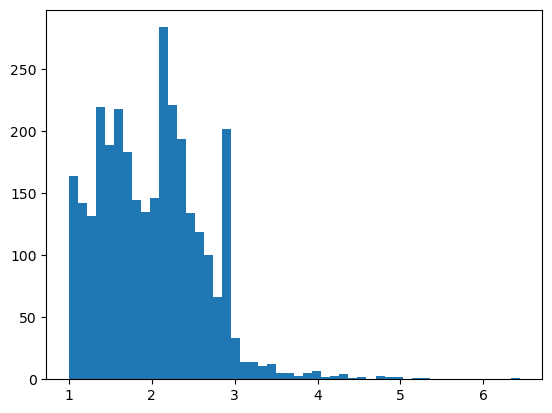

In [225]:
plt.figure()
plt.hist(ev['qmag1'], 50)
plt.show()

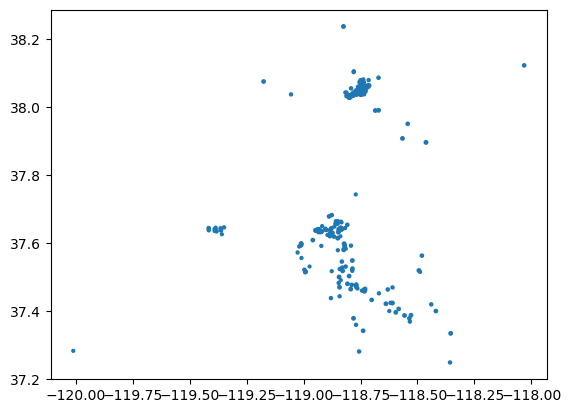

In [233]:
plt.figure()
plt.scatter(ev_calib['qlon'], ev_calib['qlat'], s=ev_calib['qmag1']**4)
plt.show()

In [274]:
ev_calib = ev[np.logical_and(
    ev['qmag1'] >= calibration_mag[0],
    ev['qmag1'] <  calibration_mag[1]
)].reset_index(drop=True)
ev_target = ev[ev['qmag1'] >= target_mag_min].reset_index(drop=True)

ncalib = len(ev_calib)
ntarget = len(ev_target)

print(f"{ncalib} possible calibration events ({nevents} events total)")
print(f"{ntarget} possible target events ({nevents} events total)")

for row in ev_target.iterrows():

    # get distances to all calibration-sized events
    dists = np.array([geodesic(
        row[1][['qlat', 'qlon']].values, 
        (ev_calib.at[i, 'qlat'], ev_calib.at[i, 'qlon'])
    ).km for i in range(ncalib)])

    # store depths as well
    depths = ev_calib['qdep'].values

    # find where calibration events are within required distance and depth
    # of target event
    calib_bool = np.logical_and(
        dists <= calibration_dist,
        np.abs(depths - row[1]['qdep']) <= calibration_depth
    )
    
    calib = ev_calib[calib_bool].reset_index(drop=True)

    plt.figure()
    plt.plot(f, calib['ev_term'].values)
    plt.show()
    raise ValueError()

339 possible calibration events (3125 events total)
1575 possible target events (3125 events total)


KeyError: 'ev_term'

<Figure size 640x480 with 0 Axes>

In [260]:
ev.at[1, 'qlat']

37.28900146484375